<h1> Image Classification using Transfer Learning on VGG16 </h1>
Conventional machine learning techniques tries to learn features from the data. However the problem arises if the dataset is not enough to learn the features required for current Image Classification task. One solution is to use **Transfer Learning** that extracts the knowledge while solving one problem and applying it to a different but related task. The architecture used here is VGG16. Features from VGG16 are used and apply it our dataset of Natural Scenes.

In [23]:
# necessary imports
import tensorflow as tf
from sklearn.datasets import load_files
import numpy as np
import os
import cv2
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
import collections
from keras.layers import BatchNormalization, GlobalAveragePooling2D, MaxPool2D, Conv2D, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.models import load_model
from keras.layers import Dense
from keras.layers import Flatten
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from google.colab import files
%matplotlib inline

<h2> Load Dataset </h2>
Here we will download the Dataset of Natural Scene from kaggel intel-image-classification and unzip it in local colab directory <br><br>


In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aamna27","key":"9944f09a800fd209ebde42468fb6f834"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d puneet6060/intel-image-classification

 97% 335M/346M [00:01<00:00, 205MB/s]
100% 346M/346M [00:01<00:00, 184MB/s]


In [6]:
!unzip intel-image-classification.zip -d Dataset
!rm -rf /content/intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/seg_train/seg_train/mountain/7506.jpg  
  inflating: Dataset/seg_train/seg_train/mountain/7537.jpg  
  inflating: Dataset/seg_train/seg_train/mountain/7539.jpg  
  inflating: Dataset/seg_train/seg_train/mountain/7551.jpg  
  inflating: Dataset/seg_train/seg_train/mountain/7560.jpg  
  inflating: Dataset/seg_train/seg_train/mountain/7565.jpg  
  inflating: Dataset/seg_train/seg_train/mountain/7578.jpg  
  inflating: Dataset/seg_train/seg_train/mountain/7581.jpg  
  inflating: Dataset/seg_train/seg_train/mountain/7586.jpg  
  inflating: Dataset/seg_train/seg_train/mountain/7647.jpg  
  inflating: Dataset/seg_train/seg_train/mountain/7652.jpg  
  inflating: Dataset/seg_train/seg_train/mountain/7654.jpg  
  inflating: Dataset/seg_train/seg_train/mountain/7662.jpg  
  inflating: Dataset/seg_train/seg_train/mountain/767.jpg  
  inflating: Dataset/seg_train/seg_train/mountain/7672.jpg  
  inflating: Dataset/seg_train/seg_

In [7]:
# A function to load data from a given directory
def load_data(data_dir):
  data = []
  labels = []
  class_dirs = os.listdir(data_dir)
  
  for direc in class_dirs:
    class_dir = os.path.join(data_dir, direc)
    for imagepath in tqdm(list(paths.list_images(class_dir))):
      image = cv2.imread(imagepath)
      image = cv2.resize(image, (32, 32))  # incase images not of same size
      data.append(image)
      labels.append(direc)
  # normalizing and converting to numpy array format
  data = np.array(data, dtype='float')/255.0
  labels = np.array(labels)
  return data, labels

In [8]:
train_dir = "Dataset/seg_train/seg_train"
val_dir = "Dataset/seg_test/seg_test"
test_dir = "Dataset/seg_pred/seg_pred"

In [9]:
!rm -rf /content/Dataset/seg_pred
!unzip Test_data.zip -d Dataset

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/seg_pred/seg_pred/street/16635.jpg  
  inflating: Dataset/seg_pred/seg_pred/street/15648.jpg  
  inflating: Dataset/seg_pred/seg_pred/street/8704.jpg  
  inflating: Dataset/seg_pred/seg_pred/street/13694.jpg  
  inflating: Dataset/seg_pred/seg_pred/street/2206.jpg  
  inflating: Dataset/seg_pred/seg_pred/street/4649.jpg  
  inflating: Dataset/seg_pred/seg_pred/street/22297.jpg  
  inflating: Dataset/seg_pred/seg_pred/street/9732.jpg  
  inflating: Dataset/seg_pred/seg_pred/street/16177.jpg  
  inflating: Dataset/seg_pred/seg_pred/street/5807.jpg  
  inflating: Dataset/seg_pred/seg_pred/street/17271.jpg  
  inflating: Dataset/seg_pred/seg_pred/street/12443.jpg  
  inflating: Dataset/seg_pred/seg_pred/street/6211.jpg  
  inflating: Dataset/seg_pred/seg_pred/street/2696.jpg  
  inflating: Dataset/seg_pred/seg_pred/street/24255.jpg  
  inflating: Dataset/seg_pred/seg_pred/street/12264.jpg  
  inflating: Dataset/seg_pre

In [10]:
print('loading train images')
X_train, y_train = load_data(train_dir)
print('loading test images')
X_val, y_val = load_data(val_dir)
print('loading test images')
X_test, y_test = load_data(test_dir)


  7%|▋         | 162/2191 [00:00<00:01, 1613.85it/s]

loading train images


 47%|████▋     | 206/437 [00:00<00:00, 2057.21it/s]

loading test images


 18%|█▊        | 209/1144 [00:00<00:00, 2089.31it/s]

loading test images


100%|██████████| 1236/1236 [00:00<00:00, 2101.87it/s]


Binarize labels in a one-vs-all fashion for train, valiadation and test data


In [11]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_val = lb.fit_transform(y_val)
y_test = lb.fit_transform(y_test)

Making dictionary to store results of experiments

In [24]:
all_acc_dict = 0
all_acc_dict = collections.OrderedDict()
accdict = {}

<h2> VGG16 Architecture </h2>

Instead of 224*224*3, input shape of 32*32*3 has been used. Apart from last four layers rest of the layers of VGG16 Architecture are frozen. A convolution layer and Relu activation is added with GlobalAveragePooling at the end. This sequence is followed by one fully connected layer and Softmax Function


In [16]:
def vgg_tl(OPTIMIZER, LEARN_RATE, DECAY, MOMEMTUM, EPOCHS):
    trained_model = VGG16(include_top=False,weights='imagenet')
    x = trained_model.output
    x = Conv2D(32, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # x = MaxPool2D()(x)
    x = GlobalAveragePooling2D()(x)
    # x = Dense(512, activation='relu')(x)
    pred_vgg= Dense(6,activation='softmax')(x)
    model = Model(inputs=trained_model.input,outputs=pred_vgg)
    
    for layer in trained_model.layers:
        layer.trainable=(1-True)
    if OPTIMIZER == "Adam":
      print(OPTIMIZER)
      LEARN_RATE = 0.01/EPOCHS 
      adam = Adam(lr=LEARN_RATE)
      model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=adam)
    if OPTIMIZER == "SGD":
      print(OPTIMIZER)
      sgd = SGD(lr=LEARN_RATE, decay=DECAY, momentum=MOMEMTUM)
      model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=sgd)

    return(model)

Train: 0.975, Test: 0.859


In [15]:
def vgg_tl(OPTIMIZER, LEARN_RATE, DECAY, MOMEMTUM, EPOCHS):
    trained_model = VGG16(include_top=False,weights='imagenet')
    x = trained_model.output
    x = Conv2D(32, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(units=512, activation='relu')(x)
    pred_vgg= Dense(6,activation='softmax')(x)
    model = Model(inputs=trained_model.input,outputs=pred_vgg)
    print(trained_model.layers)
    for layer in trained_model.layers[:4]:
        layer.trainable=(False)
    if OPTIMIZER == "Adam":
      print(OPTIMIZER)
      LEARN_RATE = 0.001/EPOCHS 
      adam = Adam(lr=LEARN_RATE)
      model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=adam)

    if OPTIMIZER == "SGD":
      print(OPTIMIZER)
      LEARN_RATE = 0.001/EPOCHS 
      sgd = SGD(lr=LEARN_RATE, decay=0, momentum=0.9)
      model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=sgd)

    if OPTIMIZER == "RMS":
      print(OPTIMIZER)
      LEARN_RATE = 0.0001/EPOCHS 
      rms = RMSprop(lr=LEARN_RATE)
      model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=rms)

    return(model)

[<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fdabc431400>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdabc362390>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdabc351f60>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fdabc3afa90>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdabc3af7f0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdabc3bc6a0>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fdab0167a58>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdab01d69b0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdab01d65f8>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdabc3bc0f0>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fdab01e17f0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdab01e1710>, <tensorflow.python.keras.layers.convo

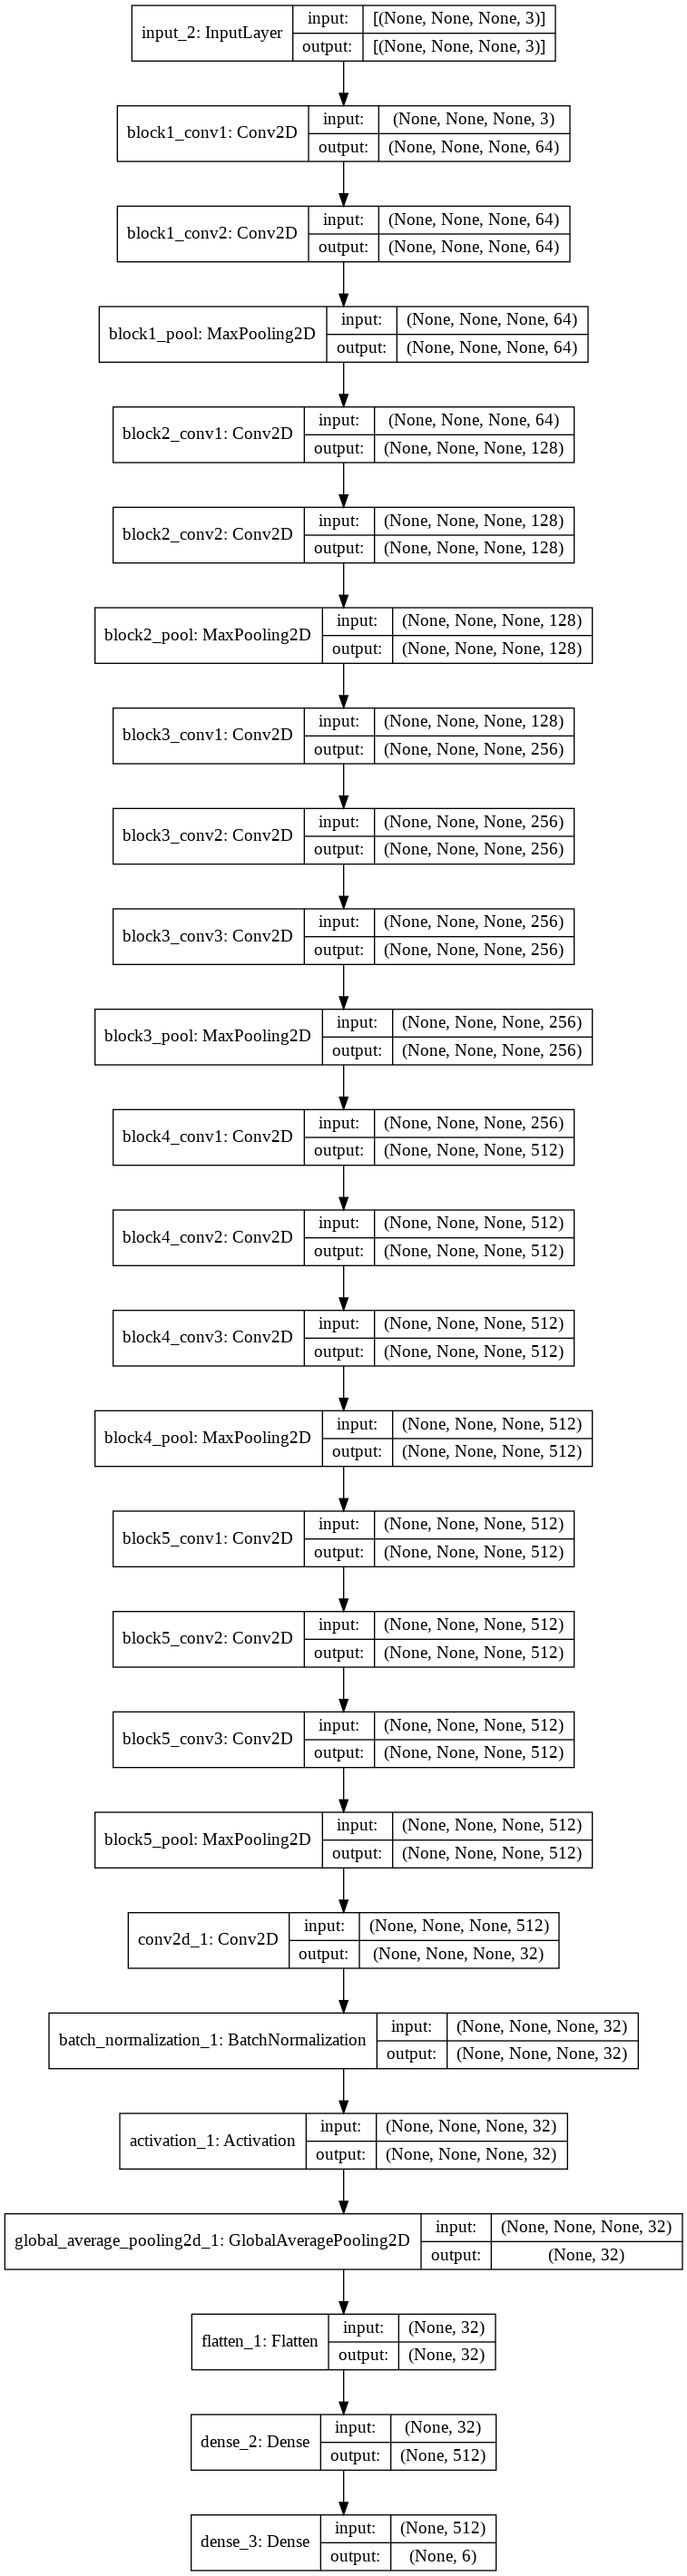

In [18]:

vgg_model_pic = vgg_tl("Adam", DECAY= 1e-7, MOMEMTUM = 0.9, LEARN_RATE =0.001, EPOCHS =75)
plot_model(vgg_model_pic, to_file='Model/VGG-TL-model.png', show_shapes=True)

In [21]:
def vgg_tl(OPTIMIZER, LEARN_RATE, DECAY, MOMEMTUM, EPOCHS):
    trained_model = VGG16(include_top=False,weights='imagenet')
    x = trained_model.output
    # x = Conv2D(32, (3,3), padding='same')(x)
    # x = BatchNormalization()(x)
    # x = Activation('relu')(x)
    # # x = MaxPool2D(padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(units=64, activation='relu')(x)
    pred_vgg= Dense(6,activation='softmax')(x)
    model = Model(inputs=trained_model.input,outputs=pred_vgg)
    print(trained_model.layers)
    for layer in trained_model.layers[:8]:
        layer.trainable=(False)
    if OPTIMIZER == "Adam":
      print(OPTIMIZER)
      LEARN_RATE = 0.001/EPOCHS #in case you want to manually set lr
      adam = Adam(lr=LEARN_RATE)  
      model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=adam)
    if OPTIMIZER == "SGD":
      LEARN_RATE = 0.01/EPOCHS #in case you want to manually set lr
      adam = Adam(lr=LEARN_RATE)
      model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=adam)
    if OPTIMIZER == "RMS":
      print(OPTIMIZER)
      sgd = SGD(lr=LEARN_RATE, decay=DECAY, momentum=MOMEMTUM)
      model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=sgd)


    return(model)

<h2> Compile and Train the Model </h2>
Using different choices of optimizers, the model is being trained. **Early Stopping** is being used to tackle number of epochs. Each time a better validation accuracy is achieved the model weights are updated in the directory.

In [19]:


es=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('CheckPoints/VGG-TL-model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

def training(BATCH_SIZE, EPOCHS, OPTIMIZER, LEARN_RATE, DECAY = 0, MOMEMTUM = 0 ):
  accdict = {}
  vgg_model = vgg_tl(OPTIMIZER,LEARN_RATE, DECAY, MOMEMTUM, EPOCHS)
  H = vgg_model.fit(X_train, y_train,
            validation_data=(X_val, y_val),
            batch_size=BATCH_SIZE,
            epochs=EPOCHS, callbacks=[es,mc])
  trainacc = H.history['accuracy']
  valacc = H.history['val_accuracy']
  trainloss = H.history['loss']
  valloss = H.history['val_loss']
  test_loss, test_acc = vgg_model.evaluate(X_test, y_test, verbose=0)
  accdict["trainacc"] =trainacc[len(trainacc)-1]
  accdict["trainloss"] =trainloss[len(trainloss)-1]
  accdict["valacc"] = valacc[len(valacc)-1]
  accdict["valloss"] = valloss[len(valloss)-1]
  accdict["testacc"] = test_acc
  accdict["testloss"] = test_loss
  
  return H, accdict
  

In [15]:
# vgg_model.save_weights('vgg_transfer_trained_wts.h5')

Experimentation including various batch sizes optimizers and learning rates are done.

In [25]:

History1, all_acc_dict["Adam_Exp1"] = training(32, 75, "Adam", 0.001)
History2, all_acc_dict["Adam_Exp2"] = training(64, 75, "Adam", 0.001)
History3, all_acc_dict["Adam_Exp3"] = training(128, 75,"Adam", 0.001) 

History4, all_acc_dict["SGD_Exp1"] = training(32, 75, "SGD", 0.001)
History5, all_acc_dict["SGD_Exp2"] = training(64, 75, "SGD", 0.001)
History6, all_acc_dict["SGD_Exp3"] = training(128, 75,"SGD", 0.001) 

History7, all_acc_dict["RMS_Exp1"] = training(32, 75, "RMS", 0.001)
History8, all_acc_dict["RMS_Exp2"] = training(64, 75, "RMS", 0.001)
History9, all_acc_dict["RMS_Exp3"] = training(128, 75,"RMS", 0.001) 

[<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fdabc3e44e0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdab0073208>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdabc453f28>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fdb083ed8d0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fda6404b908>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fda640450f0>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fda6404b470>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fda64050240>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fda64056ef0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fda6405af98>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fda6405a390>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fda5cb68978>, <tensorflow.python.keras.layers.convo

<h2> Evaluate the Model </h2>
Model is evaluated on the weights that produced the highest validation accuracy. These weights were stored during training.


In [26]:

saved_model = load_model('CheckPoints/VGG-TL-model.h5')

# evaluate the model
_, train_acc = saved_model.evaluate(X_train, y_train, verbose=0)
_, val_acc = saved_model.evaluate(X_val, y_val, verbose=0)
_, test_acc = saved_model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Val: %.3f, Test: %.3f' % (train_acc, val_acc, test_acc))

Train: 0.916, Val: 0.854, Test: 0.854


<h2> Plotting Training and Validation accuracy of different optimizers </h2>

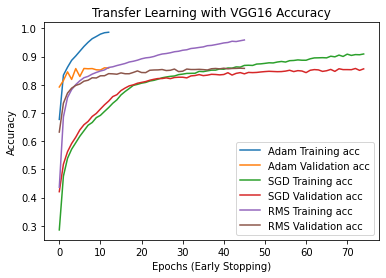

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline
History =0
History = History2
acc = History.history['accuracy']
val_acc = History.history['val_accuracy']

epochs = range(len(acc))
plt.xlabel('Epochs (Early Stopping)')
plt.ylabel('Accuracy')
plt.title('Transfer Learning with VGG16 Accuracy')

plt.plot(epochs, acc, label='Adam Training acc')
plt.plot(epochs, val_acc, label='Adam Validation acc')

History =0
History = History4
acc = History.history['accuracy']
val_acc = History.history['val_accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, label='SGD Training acc')
plt.plot(epochs, val_acc, label='SGD Validation acc')



History =0
History = History7
acc = History.history['accuracy']
val_acc = History.history['val_accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, label='RMS Training acc')
plt.plot(epochs, val_acc, label='RMS Validation acc')
plt.legend()
plt.savefig("Results/FinalTLVGG16Historyacc.png")



<h2> Plotting Training and Validation losses of different optimizers </h2>

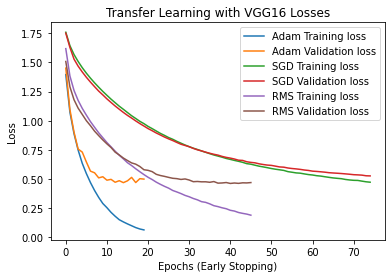

In [55]:

History =0
History = History3
loss = History.history['loss']
val_loss = History.history['val_loss']

epochs = range(len(loss))
plt.xlabel('Epochs (Early Stopping)')
plt.ylabel('Loss')
plt.title('Transfer Learning with VGG16 Losses')

plt.plot(epochs, loss, label='Adam Training loss')
plt.plot(epochs, val_loss, label='Adam Validation loss')

History =0
History = History5
loss = History.history['loss']
val_loss = History.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, label='SGD Training loss')
plt.plot(epochs, val_loss, label='SGD Validation loss')



History =0
History = History7
loss = History.history['loss']
val_loss = History.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, label='RMS Training loss')
plt.plot(epochs, val_loss, label='RMS Validation loss')
plt.legend()
plt.savefig("Results/FinalTLVGG16Historyloss.png")



In [56]:
all_acc_dict.items()

odict_items([('Adam_Exp1', {'trainacc': 0.7002280354499817, 'trainloss': 0.7002280354499817, 'valacc': 0.722000002861023, 'valloss': 0.722000002861023, 'testacc': 0.7379810810089111, 'testloss': 0.7039243578910828}), ('SGD_Exp13', {'train': 0.7612227201461792, 'val': 0.7450000047683716}), ('RMS', {'train': 0.808821439743042, 'val': 0.765333354473114}), ('Adam_Exp2', {'train': 0.7937865257263184, 'val': 0.7633333206176758}), ('Adam_Exp3', {'train': 0.7792503833770752, 'val': 0.7490000128746033}), ('SGD_Exp1', {'train': 0.7550235390663147, 'val': 0.7486666440963745}), ('SGD_Exp2', {'train': 0.738064706325531, 'val': 0.7363333106040955}), ('SGD_Exp3', {'train': 0.7236710786819458, 'val': 0.715666651725769}), ('RMS_Exp1', {'train': 0.8169445395469666, 'val': 0.7630000114440918}), ('RMS_Exp2', {'train': 0.8204360604286194, 'val': 0.7663333415985107}), ('RMS_Exp3', {'train': 0.8202223181724548, 'val': 0.762333333492279})])

Printing accuracies and losses of experiments


In [27]:

for k, v in all_acc_dict.items():
    trainacc, trainloss, valacc, valloss,testacc, testloss = v
    print(v)
    print( "".format(k, trainacc, trainloss, valacc, valloss,testacc, testloss ))

{'trainacc': 0.9557503461837769, 'trainloss': 0.1301674246788025, 'valacc': 0.8493333458900452, 'valloss': 0.4706194996833801, 'testacc': 0.8470072746276855, 'testloss': 0.5391864776611328}

{'trainacc': 0.9696451425552368, 'trainloss': 0.09644506871700287, 'valacc': 0.8423333168029785, 'valloss': 0.5282328724861145, 'testacc': 0.8412546515464783, 'testloss': 0.5653725862503052}

{'trainacc': 0.9529001116752625, 'trainloss': 0.14911046624183655, 'valacc': 0.8446666598320007, 'valloss': 0.47177910804748535, 'testacc': 0.8439939618110657, 'testloss': 0.5239457488059998}

{'trainacc': 0.9705714583396912, 'trainloss': 0.09030307829380035, 'valacc': 0.8393333554267883, 'valloss': 0.6215255856513977, 'testacc': 0.8301602602005005, 'testloss': 0.7310925722122192}

{'trainacc': 0.9796921610832214, 'trainloss': 0.06276267021894455, 'valacc': 0.8506666421890259, 'valloss': 0.6082673072814941, 'testacc': 0.8438569903373718, 'testloss': 0.7002517580986023}

{'trainacc': 0.9664386510848999, 'trainl

<h2> Predict on Unseen Images </h2>






In [30]:
saved_model = load_model('CheckPoints/VGG-TL-model.h5')
predY = saved_model.predict(X_test)

Test Label: 0
Predicted Label: 0


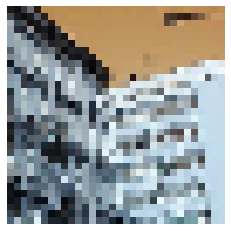

Test Label: 1
Predicted Label: 1


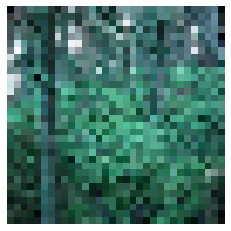

Test Label: 0
Predicted Label: 0


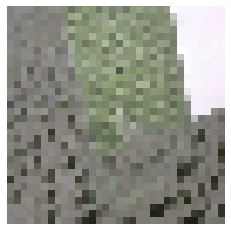

Test Label: 2
Predicted Label: 2


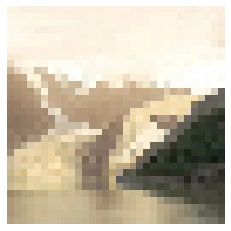

Test Label: 5
Predicted Label: 5


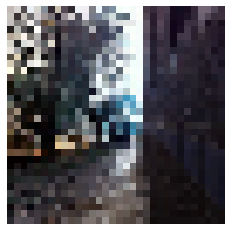

In [32]:
random = [1000, 5000, 50, 2000, len(X_test)-10]
for index in random:
 #load test image
 image = X_test[index]
 

 # Compare and visualize
 figr, (ax1) = plt.subplots(1, 1, figsize=(8, 4), sharex=True, sharey=True)
 ax1.axis('off')
 ax1.imshow(image)
 test_label = y_test.argmax(1)
 pred_label = predY.argmax(1)
 print('Test Label: {}'.format(test_label[index]))
 print('Predicted Label: {}'.format(pred_label[index]))
 plt.show()
 figr.savefig("Results/VisualzingResults"+str(index)+".jpg")

In [33]:
#Confusion Matrix
from sklearn.metrics import classification_report, accuracy_score, f1_score
from skimage import feature
from skimage import exposure
from tqdm.notebook import tqdm
from sklearn.svm import LinearSVC
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
import pandas as pd
actual = pd.Series(y_test.ravel(),name='Actual')
predicted = pd.Series(predY.ravel(),name='Predicted')
predY_classes = predY.argmax(1)
y_test_classes = y_test.argmax(1)
confusion_matrix = pd.crosstab(y_test_classes, predY_classes,margins=True)
print("Confusion matrix:\n%s" % confusion_matrix)

Confusion matrix:
col_0     0     1     2     3     4     5   All
row_0                                          
0       988    20     4    12    14   106  1144
1         8  1129     4     3     2    20  1166
2        33     8  1003   181    82    23  1330
3        31     8    93  1054   105     6  1297
4        50     3    34    68   961    12  1128
5        88    28     4     7     9  1100  1236
All    1198  1196  1142  1325  1173  1267  7301


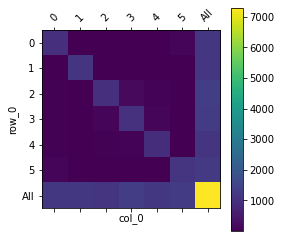

In [34]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.YlOrRd):
  plt.matshow(df_confusion) # imshow
  plt.colorbar()
  tick_marks = np.arange(len(df_confusion.columns))
  plt.xticks(tick_marks, df_confusion.columns, rotation=45)
  plt.yticks(tick_marks, df_confusion.index)
  plt.ylabel(df_confusion.index.name)
  plt.xlabel(df_confusion.columns.name)
  plt.savefig("Results/TFVGG16confusion.jpg")
#call function
plot_confusion_matrix(confusion_matrix)